---------------
#### If any part of this notebook is used in your research, please cite with the reference found in [`README.md`](https://github.com/pysal/spaghetti#bibtex-citation).
----------------
# Advanced `pysal.spaghetti` tutorial:
# Creating and visualizing a `spaghetti.Network` object
### Author: James D. Gaboardi <jgaboardi@gmail.com>
#### This notebook is an advanced walk-through for:
1. Exploring the attributes of network objects and point patterns
2. Understanding the difference between a network and its graph-theoretic representation
3. Performing spatial network analysis

In [1]:
%load_ext watermark
%watermark

2019-12-27T16:57:09-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


#### In addtion to the base spaghetti [requirements](https://github.com/pysal/spaghetti/blob/master/requirements.txt) (their dependecies), this notebook requires installations of:
* [`matplotlib`](https://matplotlib.org)
    * `$ conda install matplotlib`

--------------------------

In [28]:
import esda
import libpysal
import matplotlib
import matplotlib.pyplot as plt
import numpy
import spaghetti
%matplotlib inline
%watermark -iv

numpy      1.17.3
esda       2.1.1
spaghetti  1.3.1
libpysal   4.2.0
matplotlib 3.1.2



### Instantiate a network

In [3]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))

### Snap point patterns to the network

In [4]:
# Crimes
ntw.snapobservations(
    libpysal.examples.get_path("crimes.shp"), "crimes", attribute=True
)
# Schools
ntw.snapobservations(
    libpysal.examples.get_path("schools.shp"), "schools", attribute=False
)

### A network is composed of a single topological representation of roads and $n$ point patterns which are snapped to the network.

In [5]:
ntw.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x108c0f080>,
 'schools': <spaghetti.network.PointPattern at 0x121bd96a0>}

### Attributes for every point pattern

1. `dist_snapped` dict keyed by pointid with the value as snapped distance from observation to network arc
2. `dist_to_vertex` dict keyed by pointid with the value being a dict in the form 
        {node: distance to vertex, node: distance to vertex}
3. `npoints` point observations in set
4. `obs_to_arc` dict keyed by arc with the value being a dict in the form 
        {pointID:(x-coord, y-coord), pointID:(x-coord, y-coord), ... }
5. `obs_to_vertex` list of incident network vertices to snapped observation points
6. `points` geojson like representation of the point pattern.  Includes properties if read with attributes=True
7. `snapped_coordinates` dict keyed by pointid with the value being (x-coord, y-coord)

### Counts per link (arc or edge) are important, but should not be precomputed since we have different representations of the network (spatial and graph currently).  (Relatively) Uniform segmentation still needs to be done.

In [6]:
counts = ntw.count_per_link(ntw.pointpatterns["crimes"].obs_to_arc, graph=False)

In [7]:
sum(list(counts.values())) / float(len(counts.keys()))

2.682242990654206

### Network segmentation

In [8]:
n200 = ntw.split_arcs(200.0)

In [9]:
counts = n200.count_per_link(n200.pointpatterns["crimes"].obs_to_arc, graph=False)
sum(counts.values()) / float(len(counts.keys()))

2.0354609929078014

### Create `geopandas.GeoDataFrame` objects of the vertices and arcs

In [10]:
# 'full' unsegmented network
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

# network segmented at 200-meter increments
vertices200_df, arcs200_df = spaghetti.element_as_gdf(
    n200, vertices=n200.vertex_coords, arcs=n200.arcs
)

### Visualization of the shapefile derived, unsegmented network with vertices in a larger, blue, semi-opaque form and the distance segmented network with small, red, fully opaque vertices.

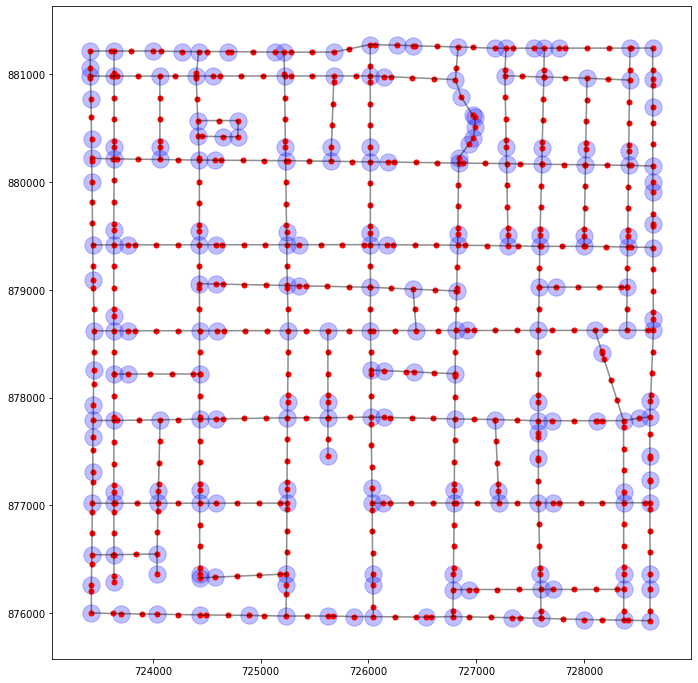

In [11]:
base = arcs_df.plot(color="k", alpha=0.25, figsize=(12, 12))
vertices_df.plot(ax=base, color="b", markersize=300, alpha=0.25)
arcs200_df.plot(ax=base, color="k", alpha=0.25)
vertices200_df.plot(ax=base, color="r", markersize=25, alpha=1.0)

### Moran's I using the digitized network

In [12]:
# Binary Adjacency
w = ntw.contiguityweights(graph=False)

# Build the y vector
arcs = w.neighbors.keys()
y = np.zeros(len(arcs))

for i, a in enumerate(arcs):
    if a in counts.keys():
        y[i] = counts[a]

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)
print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


### Moran's I using the graph representation to generate the W

* Note that we have to regenerate the counts per arc, since the graph will have less edges.

In [13]:
counts = ntw.count_per_link(ntw.pointpatterns['crimes'].obs_to_arc, graph=True)

# Binary Adjacency
w = ntw.contiguityweights(graph=True)

# Build the y vector
edges = w.neighbors.keys()
y = np.zeros(len(edges))

for i, e in enumerate(edges):
    if e in counts.keys():
        y[i] = counts[e]

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)

print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


### Moran's I using the segmented network and intensities instead of counts

In [14]:
# Binary Adjacency
w = n200.contiguityweights(graph=False)

# Compute the counts
counts = n200.count_per_link(
    n200.pointpatterns['crimes'].obs_to_arc, graph=False
)

# Build the y vector and convert from raw counts to intensities
arcs = w.neighbors.keys()
y = np.zeros(len(arcs))

for i, a in enumerate(edges):
    if a in counts.keys():
        length = n200.arc_lengths[a]
        y[i] = counts[a] / length

# Moran's I
res = esda.moran.Moran(y, w, permutations=99)

print(dir(res))

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_statistic', 'by_col', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/esda/moran.py:206: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/esda/moran.py:217: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/esda/moran.py:165: RuntimeWarning: invalid value encountered in greater_equal
  above = sim >= self.I
/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/esda/moran.py:181: RuntimeWarning: invalid value encountered in true_divide
  self.z /= sy


### Timings for distance based methods, e.g. G-function

In [15]:
t1 = time.time()
n0 = ntw.allneighbordistances(ntw.pointpatterns['crimes'])
print(time.time()-t1)

0.45281219482421875


In [16]:
t1 = time.time()
n1 = n200.allneighbordistances(n200.pointpatterns['crimes'])
print(time.time()-t1)

1.844743013381958


* Note that the first time these methods are called, the underlying vertex-to-vertex shortest path distance matrix has to be calculated. Subsequent calls will not require this, and will be much faster:

In [17]:
t1 = time.time()
n0 = ntw.allneighbordistances(ntw.pointpatterns['crimes'])
print(time.time()-t1)

0.17812275886535645


In [18]:
%timeit ntw.allneighbordistances(ntw.pointpatterns["crimes"])

174 ms ± 7.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
print(dir(ntw))

['NetworkF', 'NetworkG', 'NetworkK', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_evaluate_napts', '_extractnetwork', '_newpoint_coords', '_round_sig', '_snap_to_link', '_yield_napts', '_yieldneighbor', 'adjacencylist', 'alldistances', 'allneighbordistances', 'arc_lengths', 'arcs', 'arcs_to_edges', 'compute_distance_to_vertices', 'compute_snap_dist', 'contiguityweights', 'count_per_link', 'distancebandweights', 'distancematrix', 'edge_lengths', 'edges', 'enum_links_vertex', 'extract_components', 'extractgraph', 'full_distance_matrix', 'graph_component2edge', 'graph_component_is_ring', 'graph_component_labels', 'graph_n_components', 'in_data', 'loadnetwork', 'nearestneighbordistances', 'netw

In [20]:
n1 = n200.allneighbordistances(n200.pointpatterns['crimes'])

### Simulate a point pattern on the network

* Need to supply a count of the number of points and a distirbution (default is uniform).  Generally, this will not be called by the user, since the simulation will be used for Monte Carlo permutation.

In [21]:
npts = ntw.pointpatterns['crimes'].npoints
sim = ntw.simulate_observations(npts)
sim

### F-function

In [22]:
fres = ntw.NetworkF(ntw.pointpatterns['crimes'],
                    permutations=99)

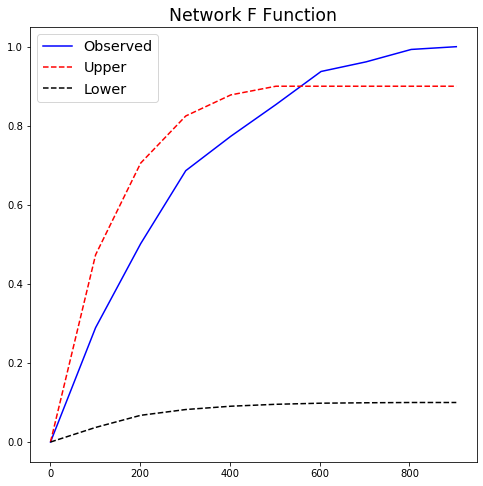

In [23]:
plt.figure(figsize=(8,8))
plt.plot(fres.xaxis, fres.observed, 'b-', linewidth=1.5, label='Observed')
plt.plot(fres.xaxis, fres.upperenvelope, 'r--', label='Upper')
plt.plot(fres.xaxis, fres.lowerenvelope, 'k--', label='Lower')
plt.legend(loc='best', fontsize='x-large')
plt.title('Network F Function', fontsize='xx-large')
plt.show()

### Create a nearest neighbor matrix using the crimes point pattern

* [note from jlaura] Right now, both the G and K functions generate a full distance matrix.  This is because, I know that the full generation is correct and I believe that the truncated generated, e.g. nearest neighbor, has a bug.

### G-function

In [24]:
gres = ntw.NetworkG(ntw.pointpatterns['crimes'], permutations=99)

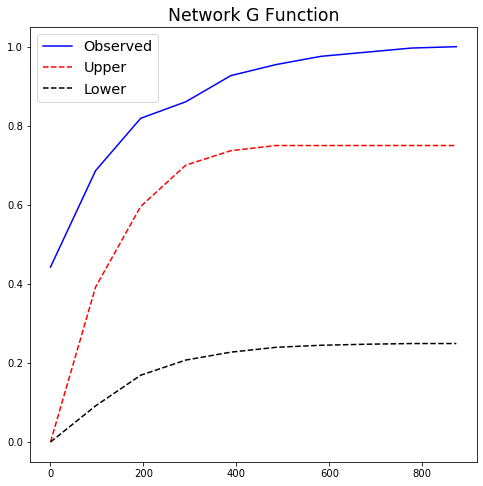

In [25]:
plt.figure(figsize=(8,8))
plt.plot(gres.xaxis, gres.observed, 'b-', linewidth=1.5, label='Observed')
plt.plot(gres.xaxis, gres.upperenvelope, 'r--', label='Upper')
plt.plot(gres.xaxis, gres.lowerenvelope, 'k--', label='Lower')
plt.legend(loc='best', fontsize='x-large')
plt.title('Network G Function', fontsize='xx-large')
plt.show()

### K-function

In [26]:
kres = ntw.NetworkK(ntw.pointpatterns['crimes'], permutations=99)

/Users/jgaboardi/spaghetti/spaghetti/analysis.py:401: RuntimeWarning: invalid value encountered in less_equal
  y[i] = len(nearest[nearest <= r])


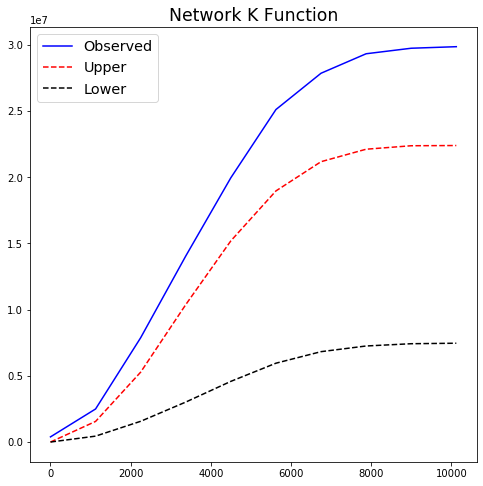

In [27]:
plt.figure(figsize=(8,8))
plt.plot(kres.xaxis, kres.observed, 'b-', linewidth=1.5, label='Observed')
plt.plot(kres.xaxis, kres.upperenvelope, 'r--', label='Upper')
plt.plot(kres.xaxis, kres.lowerenvelope, 'k--', label='Lower')
plt.legend(loc='best', fontsize='x-large')
plt.title('Network K Function', fontsize='xx-large')
plt.show()

-----------